# GAN to assist in Melanoma Detection

[melanoma competition](https://www.kaggle.com/c/siim-isic-melanoma-classification/data)


In [119]:
import glob
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from IPython import display

2.13.0


## Why use GAN?

* Dataset target classes are highly imbalance, only 1.76% of malignant

## Interesting topics to try

1. GAN to generate additional malignant class images
2. Using VAEs to train anomaly detection from benign (non lethal) lesion
3. GAN to generate SR and additional attention based cropping for train a better lesion classifier and detector

In [120]:
# asign some paths
train_csv_path = './dataset/siim-isic-melanoma-classification/train.csv'
test_csv_path = './dataset/siim-isic-melanoma-classification/test.csv'
image_path = './dataset/siim-isic-melanoma-classification/jpeg/train/'

# read the csv data using pandas
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print("unique values in column 'target': {}".format(list(train_df['target'].unique())))
target_dis = list(train_df['target'].value_counts())
benign_per = target_dis[0]/sum(target_dis)
print("target count distribution: {}".format(target_dis))
print("benign percentage: {:.2f}% vs malignant: {:.2f}%".format(benign_per*100, (1-benign_per)*100))

unique values in column 'target': [0, 1]
target count distribution: [32542, 574]
benign percentage: 98.27% vs malignant: 1.73%


## 1. DCGAN to generate Malignant images

Source
* [code](https://www.tensorflow.org/tutorials/generative/dcgan) 
* [GAN-based Synthetic Medical Image Augmentation](https://arxiv.org/pdf/1803.01229.pdf)

Dataset
* [JPEG 128x128](https://www.kaggle.com/cdeotte/jpeg-melanoma-128x128) melanoma from Chris Deotte

Problems:
* Generated images are nowhere near the input images
* Maybe needs some augmentation. [Augmentation in GAN](https://arxiv.org/pdf/2006.05338v1.pdf) 

In [121]:
# detect and initialize TPU (ignore if using GPU)
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     # set distribution strategy
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

# # Use these params if using TPU
# IMAGE_SIZE = [128, 128]  # used for reshaping
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# GCS_PATH = KaggleDatasets().get_gcs_path('melanoma-128x128')  # store dataset to gcs buckets for the TPU to access in cloud
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync

### Preprocess Image

In [122]:
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image

path_jpg = './dataset/jpeg-melanoma-128x128/train/'
IMAGE_SIZE = [128, 128]

malignant = train_df[train_df["target"] == 1]  # list of malignant images

def preprocess_X():  # load the images into memory
    X = []
    for img in malignant.image_name.values:
        img_name = path_jpg + img + '.jpg'
        i = Image.open(img_name) #color_mode='grayscale')
        i = tf.keras.preprocessing.image.img_to_array(i)
        i = preprocess_input(i)  # preprocessing fits the pixel value from -127.5 to 127.5
        X.append(i)
    return np.array(X)  # convert to numpy array

In [123]:
X = preprocess_X()
X.shape

(574, 128, 128, 3)

### Display preprocessed image

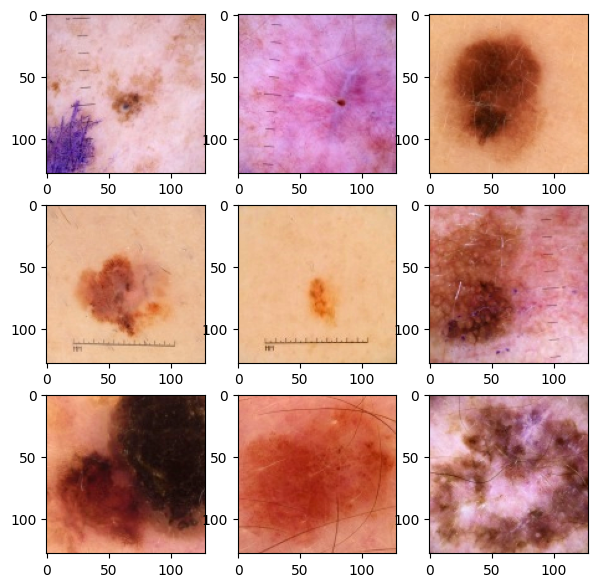

In [124]:
def display_img(arr):
    i = tf.keras.preprocessing.image.array_to_img(arr)
    plt.imshow(i, cmap='gray')

plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3,3, i+1)
    display_img(X[i])  

### Hyperparameters

In [125]:
BUFFER_SIZE = 584
BATCH_SIZE = 32  # from 128
EPOCHS = 50  # from 50
noise_dim = 200  # from 100
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### Increase training data with Augmentations

In [126]:
def augmentation_pipeline(image):
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.resize(image, IMAGE_RESIZE)
    return image

In [127]:
# Simple dataset processing with batch and shuffle
def get_dataset():
    ds = tf.data.Dataset.from_tensor_slices(X)
#     ds = ds.map(augmentation_pipeline)
    ds = ds.shuffle(BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    return ds
    
train_dataset = get_dataset()
# inspect a batch
n_batch = 0
for i in train_dataset:
    n_batch += 1
print(f"num of batch: {n_batch}, shape of each batch: {i.shape}")

num of batch: 18, shape of each batch: (30, 128, 128, 3)


### Create Generator and Discriminator

In [128]:
def make_generator_model():
    model = tf.keras.Sequential()   # dense unit is configured to match soon tobe reshaped layer
    model.add(layers.Dense(32*32*256, use_bias=False, input_shape=(noise_dim,)))  # starts with 1D array, input is noise array of 100
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 32x32 bcz there's 2 conv2D. 128/2/2=32
    model.add(layers.Reshape((32, 32, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# create the generator
generator = make_generator_model()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 262144)            52428800  
                                                                 
 batch_normalization_6 (Bat  (None, 262144)            1048576   
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 262144)            0         
                                                                 
 reshape_2 (Reshape)         (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 32, 32, 128)       819200    
 Transpose)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 32, 32, 128)      

Display an image generated from noise (G still not trained yet)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


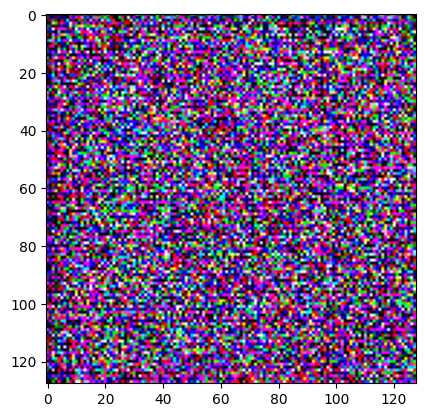

In [129]:
noise = tf.random.normal([1, noise_dim])  # outputs random values from normal dist. to a certain array shape
generated_image = generator(noise, training=False)  # interesting, doesn't need .fit .predict or anything

plt.imshow(generated_image[0, :, :, :]*255)#, cmap='gray')

In [130]:
def make_discriminator_model():
    model = tf.keras.Sequential()   # basic binary classification model
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# create D
discriminator = make_discriminator_model()
print(discriminator.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 131072)           

Let the untrained D predict that generated image

In [131]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00307758]], shape=(1, 1), dtype=float32)


## Define Loss and Optimizer

In [132]:
# This method returns a helper function to compute cross entropy loss (prob between 0 and 1)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss
measures how well D distinguish real and fake images. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [133]:
def discriminator_loss(real_output, fake_output):
    # ones_like creates array of ones with similar shape as the input array
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss
Measures how well G can trick D. If G is performing well, D will classify fake images as 1 (real)
the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s. Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [134]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

In [135]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)  # but here they use the same Adam anyway
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Create callbacks

In [136]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Defining training loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fake images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [137]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [141]:
from tqdm import tqdm

def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
        start = time.time()

        for image_batch in tqdm(dataset):
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

In [142]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=True)  # same as num_examples_to_generate
    fig = plt.figure(figsize=(12,12))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./gan_model_image/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [143]:
train(train_dataset, EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:18<?, ?it/s]


KeyboardInterrupt: 

## 2. GAN for anomali detection

* Anomali detection in Alzheimer Disease with GAN
* SHOW RESULTS

* Also other research that has anomali results: HERE HERE and HERE
* Very effective when positive samples are rare, it's also a how doctors learn to classify
* But in melanoma, is it really effective? since the difference between benign and malignant images can sometimes be **very subtle**

### 2.1 Papers on anomali detection

* [Lesion detection in Brain MRI with constrained adversarial auto-encoder](https://arxiv.org/pdf/1806.04972.pdf)
* 

In [ ]:
benign = train_df[train_df["target"] == 0]
malignant = train_df[train_df["target"] == 1]

def show_img(target, n=16):
    img_name = target.image_name.values
    ex_img = np.random.choice(img_name, n)  # grab n number of images
    plt.figure(figsize=(15,15))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        img = plt.imread(image_path + ex_img[i]+'.jpg')
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

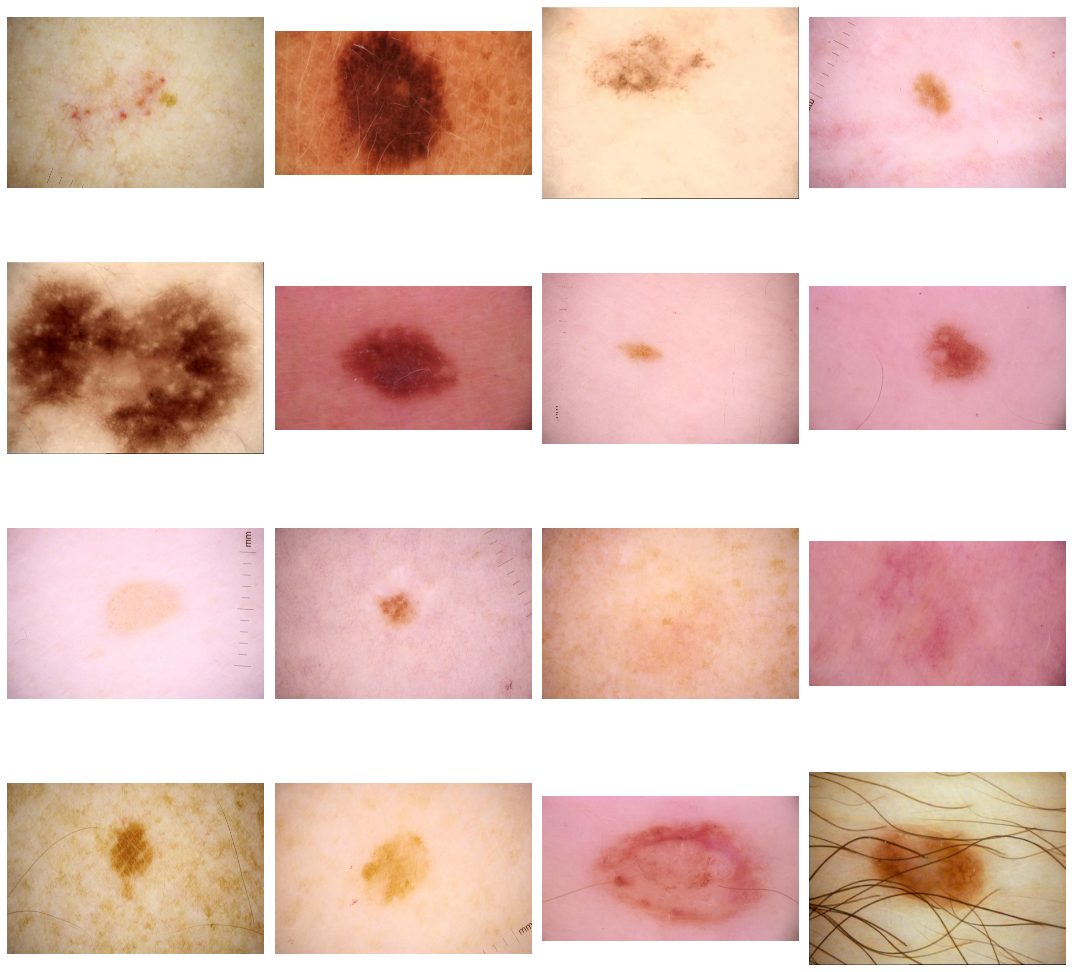

In [ ]:
show_img(benign)

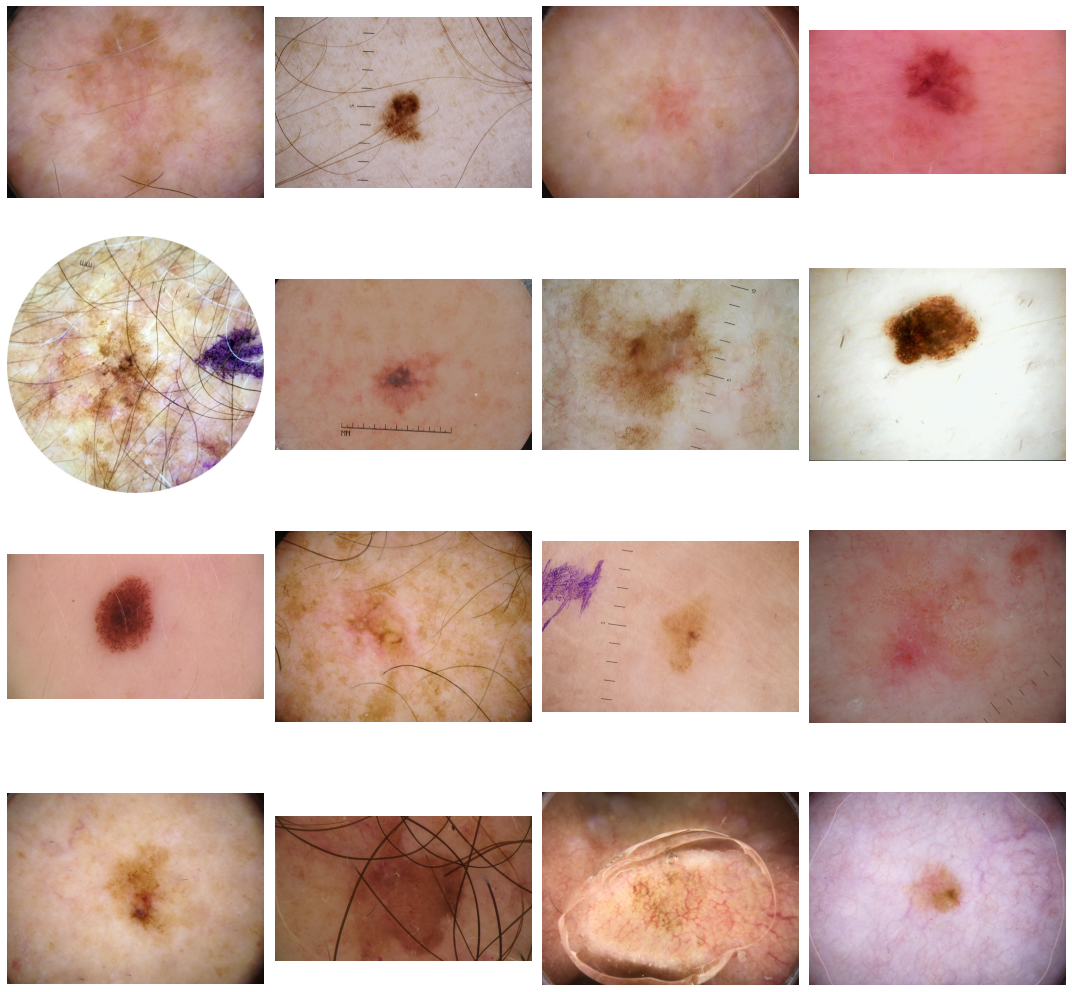

In [ ]:
show_img(malignant)